In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import adams_bashforth as ab
import midpoint as md
import heun as he
import cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6.75, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 1
seed=67

t_data = np.linspace(0, tf, tf*100+1)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[1], 'GLS': defcolors[2]}

# Solvers
solvers_ef = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ef.solve_ivp, dim), 
             'cubic': cbmos.CBMSolver(ff.cubic, ef.solve_ivp, dim),
             'GLS': cbmos.CBMSolver(ff.gls, ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

# Adaptive time-stepping for two cells after proliferation

In [4]:
cell_list = [cl.Cell(0, [0], proliferating=False), cl.Cell(1, [0.3], proliferating=False)]

Initial step cubic 0.010485971970578002
Stability bound estimate cubic 0.7036500005799682
Initial step pw. quad. 0.016988433118402646
Stability bound estimate pw. quad. 0.6658008357884931
Initial step GLS 0.026558094536932936
Stability bound estimate GLS 0.554579148481648


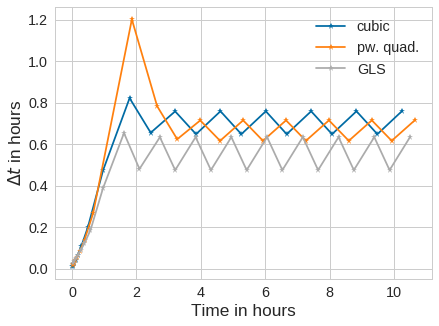

In [15]:
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    history = solvers_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "out": filename_ending[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts, dts,'-*', label=force)
plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.savefig('adaptivity_pairwise_relaxation.pdf', bbox_inches='tight')
plt.savefig('adaptivity_pairwise_relaxation.png', bbox_inches='tight')

Initial step cubic 0.003146312345143595
Stability bound estimate cubic 0.7017739704757591
Initial step pw. quad. 0.005259029485161615
Stability bound estimate pw. quad. 0.663987183476891
Initial step GLS 0.008126547046893426
Stability bound estimate GLS 0.5162951229243763


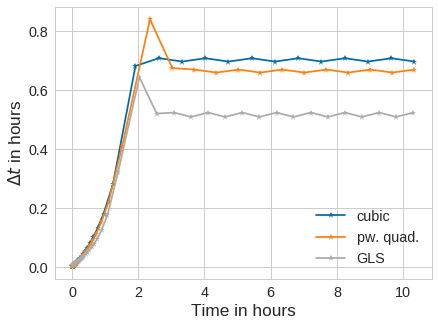

In [14]:
for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
        os.remove('time_points'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    history = solvers_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.001, "out": filename_ending[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts, dts,'-*', label=force)
plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
plt.savefig('adaptivity_pairwise_relaxation_eps0_001.pdf', bbox_inches='tight')
plt.savefig('adaptivity_pairwise_relaxation_eps0_001.png', bbox_inches='tight')


# Dependence of stability bound on number of neigbors